In [1]:
import os
import sys
sys.path.append("../bottlenecks")
import configs
from cbm import *
from data_utils import *
from trainer_utils import *
from graph_plot_tools import *
from utils import *
from metric_utils import *
from peft import LoraConfig, get_peft_model
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

2024-03-19 13:12:06.320875: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 13:12:06.321013: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 13:12:06.321290: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 13:12:06.345693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 13:12:07.509125: W tensorflow/compiler/

In [5]:
configs.set_seed(42)
device = configs.set_device(3)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-PCIE-40GB


In [6]:
plt.style.use("seaborn-v0_8")

In [7]:
class BaseCBModelWithLora(torch.nn.Module):
    def __init__(
        self,
        num_concepts: int,
        num_classes: int,
        backbone_name: str = "openai/clip-vit-base-patch32",
        train_backbone: bool = False,
        num_loras: int = 1,
        lora_rank: int = 8,
        lora_alpha: int = 8,
        lora_dropout: float = 0.0,
        connect_to: str = "last",
    ):
        super().__init__()
        if backbone_name == Constants.altclip_link:
            backbone = transformers.AltCLIPModel.from_pretrained(backbone_name)
            self.processor = transformers.AltCLIPProcessor.from_pretrained(
                backbone_name
            )
        elif backbone_name == Constants.align_link:
            backbone = transformers.AlignModel.from_pretrained(backbone_name)
            self.processor = transformers.AlignProcessor.from_pretrained(backbone_name)
        else:
            backbone = transformers.CLIPModel.from_pretrained(backbone_name)
            self.processor = transformers.CLIPProcessor.from_pretrained(backbone_name)
        for param in backbone.parameters():
            param.requires_grad = train_backbone
        self.num_loras = num_loras
        self.lora_rank = lora_rank
        self.lora_alpha = lora_alpha
        self.lora_dropout = lora_dropout
        self.connect_to = connect_to
        if self.connect_to == "last":
            target_modules = ["visual_projection"]
        elif self.connect_to == "self-attn":
            target_modules = ["k_proj", "q_proj", "v_proj",
                             "out_proj",]
        elif self.connect_to == "vit-self-attn":
            target_modules = []
        elif self.connect_to == "text-self-attn":
            target_modules = []
        peft_config = LoraConfig(
            r=self.lora_rank,
            lora_alpha=self.lora_alpha,
            lora_dropout=self.lora_dropout,
            target_modules=target_modules,
        )
        for i in range(self.num_loras):
            self.backbone = get_peft_model(
                backbone, peft_config, adapter_name=f"lora{i}"
            )
        for name, p in self.backbone.named_parameters():
            if "lora" in name:
                p.requires_grad_(True)
                
        self.cbl = nn.Linear(num_concepts, num_concepts, bias=False)
        self.head = nn.Linear(num_concepts, num_classes, bias=False)

    def forward(self, **batch):
        cbl_out = self.cbl(self.backbone(**batch).logits_per_image)
        return cbl_out, self.head(cbl_out)

## test trainer with LoRA

In [23]:
# draw norm hists and compute norm diffs functions to be released
# make tau in GumbelSoftmaxContrastiveLoss trainable
# check is savefig works correctly
# add functions that plot metrics and losses after training
# add functions that draw an interpretability bars with conf matrices

import os
import time
import torch
import warnings
import numpy as np
from graph_plot_tools import *
from cbm import *
from utils import *
from configs import *
from metric_utils import *
from evaluate import load
from IPython import display
from matplotlib import animation

def init_history(run_name, nets, opts, displayed_names, bs_muls):
    hist = []
    for net, optimizer, displayed_name, bs_mul in zip(nets, opts, displayed_names, bs_muls):
        hist.append(
            {
                "run_name": run_name,
                "name": displayed_name,
                "bs_mul": bs_mul,
                "train_loss": [],
                "train_x": [],
                "val_loss": [],
                "val_x": [],
                "train_cbl_loss": [],
                "val_cbl_loss": [],
                "train_acc_top_1": [],
                "train_acc_top_5": [],
                "test_acc_top_1": [],
                "test_acc_top_5": [],
                "val_acc_top_1": [],
                "val_acc_top_5": [],
                "val_precision": [],
                "val_recall": [],
                "val_f1": [],
                "test_precision": [],
                "test_recall": [],
                "test_f1": [],
                "norm_diffs": [],
                "epochs_x": [],
                "norm_diffs_x": [],
                "total_steps": 0,
                "prev_val_eval_step": 0,
                "prev_grad_norms_eval_step": 0,
                "batch_end": True,
            }
        )
    return hist 


class CBMConfig:
    def __init__(
        self,
        num_nets: int,
        num_concepts: int,
        num_classes: int,
        run_name: str,
        net_types: list,
        backbones: list,
        displayed_names: list,
        training_methods: list,
        optimizers: list,
        lrs: list,
        cbl_lrs: list,
        train_backbones: list,
        lora_connections: list = [],
    ):
        self.num_nets = num_nets
        self.num_concepts = num_concepts
        self.num_classes = num_classes
        self.run_name = run_name
        self.net_types = net_types
        self.backbones = backbones
        self.displayed_names = displayed_names
        self.training_methods = training_methods
        self.optimizers = optimizers
        self.lrs = lrs
        self.cbl_lrs = cbl_lrs
        self.train_backbones = train_backbones
        self.lora_connections = lora_connections
        self.bs_muls = [1] * self.num_nets
        assert (
            self.num_nets
            == len(self.net_types)
            == len(self.backbones)
            == len(self.training_methods)
            == len(self.optimizers)
            == len(self.lrs)
            == len(self.cbl_lrs)
            == len(self.train_backbones)
            == len(self.bs_muls)
        ), "These lists must be of the same length."
        assert len(self.lora_connections) == len(
            [n for n in self.net_types if n == "lora"]
        ), "LoRA connections must match the number of models with LoRA."
        self.optimizers_dict = {
            "Adam": torch.optim.Adam,
            "AdamW": torch.optim.AdamW,
            "SGD": torch.optim.SGD,
        }

    def _create_models_and_optimizers(self):
        torch.cuda.empty_cache()
        nets, opts = [], []
        lora_cnt = 0
        for _ in range(self.num_nets):
            for net_type, backbone_name, train_backbone, opt_name, lr, cbl_lr in zip(
                self.net_types,
                self.backbones,
                self.train_backbones,
                self.optimizers,
                self.lrs,
                self.cbl_lrs,
            ):
                if net_type == "base":
                    nets.append(
                        BaseCBModel(
                            num_concepts=self.num_concepts,
                            num_classes=self.num_classes,
                            backbone_name=backbone_name,
                            train_backbone=train_backbone,
                        )
                    )
                    nets[-1].zero_grad()
                    nets[-1].train()
                    opts.append(
                        (
                            self.optimizers_dict[opt_name](
                                nets[-1].cbl.parameters(), lr=cbl_lr
                            ),
                            self.optimizers_dict[opt_name](
                                [{"head": nets[-1].head.parameters(),
                                  "params": [p for p in nets[-1].parameters() if p.requires_grad]}], lr=lr
                                #nets[-1].head.parameters(), lr=lr
                            ),
                        )
                    )
                elif net_type == "lora":
                    nets.append(
                        BaseCBModelWithLora(
                            num_concepts=self.num_concepts,
                            num_classes=self.num_classes,
                            backbone_name=backbone_name,
                            train_backbone=train_backbone,
                            connect_to=self.lora_connections[lora_cnt],
                        )
                    )
                    nets[-1].zero_grad()
                    nets[-1].train()
                    if self.lora_connections[lora_cnt] == "last":
                        opts.append(
                            (
                                self.optimizers_dict[opt_name](
                                    nets[-1].cbl.parameters(), lr=cbl_lr
                                    #[{"params": nets[-1].backbone.visual_projection.parameters(),
                                     #"params": nets[-1].cbl.parameters()}], lr=cbl_lr
                                ),
                                self.optimizers_dict[opt_name](
                                    #nets[-1].head.parameters(), lr=lr
                                    [{"params": nets[-1].backbone.visual_projection.parameters(),
                                     "params": nets[-1].head.parameters()}], lr=lr
                                ),
                            )
                        )
                    #lora count fix
                    #print(lora_cnt, len(self.lora_connections))
                    #lora_cnt += 1
                    #if lora_cnt != len(self.lora_connections):
                    #    lora_cnt += 1
                    #print(lora_cnt, len(self.lora_connections))
                # backbone won't be trained yet, because we connect optimizer only to the head.parameters()
        return nets, opts

    def unpack(self):
        nets, opts = self._create_models_and_optimizers()
        hist = init_history(
            self.run_name, nets, opts, self.displayed_names, self.bs_muls
        )
        return nets, opts, hist, self.run_name, self.training_methods


class BottleneckTrainer:
    def __init__(
        self,
        config,
        train_loader,
        val_loader,
        test_loader,
        num_epochs=10,
        device=None,
        lr_decay=1.0,
        batch_mul_step_count=500,
        norm_diffs_step_count=500,
        val_step_count=500,
        gumbel_hard=False,
        gumbel_tau=1.0,
        l1_lambda=1e-3,
        is_cubed=False,
        report_to=Optional[str],
    ):
        nets, opts, hist, run_name, training_methods = config.unpack()
        self.nets = nets
        self.opts = opts
        self.hist = hist
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = torch.nn.CrossEntropyLoss()
        self.training_methods = training_methods
        self.criterion_gumbel = criterion_gumbel
        self.criterion_contrastive = criterion_contrastive
        self.criterion_l1 = criterion_l1
        self.criterion_similarity = criterion_similarity
        self.precision_metric = load("precision")
        self.recall_metric = load("recall")
        self.f1_metric = load("f1")
        self.lr_decay = lr_decay
        self.run_name = run_name
        self.num_epochs = num_epochs
        self.batch_mul_step_count = batch_mul_step_count
        self.norm_diffs_step_count = norm_diffs_step_count
        self.val_step_count = val_step_count
        self.calc_norm_diffs = False
        self.gumbel_hard = gumbel_hard
        self.gumbel_tau = gumbel_tau
        self.l1_lambda = l1_lambda
        self.is_cubed = is_cubed
        self.report_to = report_to

    def _update_learning_rate(self, param_groups, decay):
        for g in param_groups:
            g["lr"] = g["lr"] * decay

    def train(self):
        num_epochs = self.num_epochs
        batch_mul_step_count = self.batch_mul_step_count
        norm_diffs_step_count = self.norm_diffs_step_count
        val_step_count = self.val_step_count
        calc_norm_diffs = self.calc_norm_diffs

        run_name = self.run_name
        os.makedirs(run_name, exist_ok=True)

        if self.report_to == "wandb":
            run = wandb.init(name=self.run_name, resume=False)

        for epoch in range(num_epochs):
            for net, opt, net_hist, training_method in zip(
                self.nets, self.opts, self.hist, self.training_methods
            ):
                net.to(self.device)
                bs_mul = net_hist["bs_mul"]
                total_steps = net_hist["total_steps"]

                if net_hist["bs_mul"] == "linear":
                    bs_mul = int(total_steps / batch_mul_step_count) + 1

                net_hist["epochs_x"].append(total_steps)
                optimizer_cbl, optimizer_head = opt

                for i, batch in enumerate(self.train_loader, 0):

                    if (
                        calc_norm_diffs
                        and (
                            (total_steps - net_hist["prev_grad_norms_eval_step"])
                            > norm_diffs_step_count
                            or len(net_hist["norm_diffs"]) == 0
                        )
                        and net_hist["batch_end"]
                    ):
                        net_hist["prev_grad_norms_eval_step"] = total_steps
                        net.eval()

                        norm_diffs = self._compute_norm_diffs(
                            net,
                            optimizer_head,
                            None,
                            train_loader_wo_crops,
                            train_loader_wo_crops,
                            repeats=5,
                        )

                        net_hist["norm_diffs"].append(norm_diffs)
                        net_hist["norm_diffs_x"].append(total_steps)
                        net.train()

                    net_hist["batch_end"] = False

                    self._update_learning_rate(
                        optimizer_head.param_groups, self.lr_decay
                    )

                    inputs, labels = batch
                    inputs, targets = inputs.to(self.device), torch.LongTensor(
                        labels
                    ).to(self.device)
                    cbl_logits, logits = net(**inputs)

                    ########
                    # cbl_mean = torch.mean(cbl_logits)#, dim=0, keepdim=True)
                    # cbl_std = torch.std(cbl_logits)#, dim=0, keepdim=True)
                    # cbl_logits = (cbl_logits - cbl_mean) / cbl_std
                    ########

                    cbl_loss = None  # test this line
                    if training_method == "gumbel":
                        cbl_loss = self.criterion_gumbel(
                            cbl_logits, tau=self.gumbel_tau, hard=self.gumbel_hard
                        )
                    elif training_method == "contrastive":
                        cbl_loss = self.criterion_contrastive(cbl_logits)
                    elif training_method == "l1":
                        cbl_loss = (
                            self.criterion_l1(net, l1_lambda=self.l1_lambda)
                            / cbl_logits.squeeze().shape[1]
                        )
                    elif training_method == "similarity":
                        cbl_loss = -self.criterion_similarity(
                            net.backbone(**inputs).logits_per_image,
                            cbl_logits,
                            self.is_cubed,
                        )

                    cbl_loss.backward(retain_graph=True)
                    ce_loss = self.criterion(logits, targets) / bs_mul
                    ce_loss.backward()

                    if total_steps % bs_mul == bs_mul - 1:
                        optimizer_cbl.step()
                        optimizer_cbl.zero_grad()
                        optimizer_head.step()
                        optimizer_head.zero_grad()
                        net_hist["batch_end"] = True

                    net_hist["train_loss"].append(
                        ce_loss.detach().cpu().item() * bs_mul
                    )
                    net_hist["train_cbl_loss"].append(
                        cbl_loss.detach().cpu().item() * bs_mul
                    )
                    net_hist["train_x"].append(total_steps)

                    if total_steps % bs_mul == bs_mul - 1:
                        if net_hist["bs_mul"] == "linear":
                            net_hist["bs_mul"] = (
                                int(int(total_steps) / batch_mul_step_count) + 1
                            )
                            bs_mul = net_hist["bs_mul"]

                    top_1, top_5 = self._accuracy(logits, targets, topk=(1, 5))
                    net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
                    net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

                    prev_val_eval_step = net_hist["prev_val_eval_step"]
                    if (total_steps - prev_val_eval_step) > val_step_count and net_hist[
                        "batch_end"
                    ]:
                        net_hist["prev_val_eval_step"] = total_steps

                        net.eval()

                        (
                            val_cbl_losses,
                            val_ce_losses,
                            val_top_1_accs,
                            val_top_5_accs,
                            val_top_1_precisions,
                            val_top_1_recalls,
                            val_top_1_f1scores,
                        ) = self._evaluate(net, self.val_loader, training_method)

                        net_hist["val_loss"].append(np.mean(val_ce_losses))
                        net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                        net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                        net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))

                        net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                        net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                        net_hist["val_f1"].append(np.mean(val_top_1_f1scores))

                        net_hist["val_x"].append(total_steps)
                        net.train()

                    if total_steps % 10 == 0:
                        start_time = time.time()
                        self._display_results(net_hist)

                    total_steps += 1

                    net_hist["total_steps"] = total_steps
                 
                if (net_hist["total_steps"] - net_hist["prev_val_eval_step"]) > val_step_count and net_hist["batch_end"]:
                    self.save_checkpoint(
                        epoch, net, optimizer_cbl, optimizer_head, net_hist
                    )
            if self.report_to == "wandb": 
                run.log({
                    "train loss":  net_hist["train_loss"],
                    "train cbl loss": net_hist["train_cbl_loss"],
                    "train accuracy top 1": net_hist["train_acc_top_1"],
                    "train accuracy top 5": net_hist["train_acc_top_5"],
                    "val loss": net_hist["val_loss"],
                    "val cbl loss": net_hist["val_cbl_loss"],
                    "val accuracy top 1": net_hist["val_acc_top_1"],
                    "val accuracy top 5": net_hist["val_acc_top_5"],
                    "val precision": net_hist["val_precision"],
                    "val recall": net_hist["val_recall"],
                    "val f1": net_hist["val_f1"],
                })
        print("Finished Training")

    def save_checkpoint(self, epoch, net, optimizer_cbl, optimizer_head, net_hist):
        state_dict = {
            "epoch": epoch,
            str(net_hist["val_acc_top_1"][-1])[:5]
            + "_model_state_dict": net.state_dict(),
            "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
            "optimizer_head_state_dict": optimizer_head.state_dict(),
            "loss_train": net_hist["train_loss"],
            "cbl_loss_train": net_hist["train_cbl_loss"],
            "loss_val": net_hist["val_loss"],
            "cbl_loss_val": net_hist["val_cbl_loss"],
        }
        torch.save(
            state_dict,
            os.path.join(
                self.run_name,
                str(net_hist["val_acc_top_1"][-1])[:5]
                + f"_checkpoint_{epoch}_epoch.pth",
            ),
        )

    def _compute_norm_diffs(
        self, net, optimizer, scheduler, train_loader, valid_loader, repeats
    ):
        pass

    def _accuracy(self, output, target, topk=(1,)):
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred)).contiguous()
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

    @torch.no_grad()
    def _evaluate(self, net, loader, training_method):
        cbl_losses, ce_losses = [], []
        top_1_accs, top_5_accs = [], []
        top_1_precisions, top_1_recalls = [], []
        top_1_f1scores = []

        with torch.no_grad():
            for step, batch in enumerate(loader, 0):
                warnings.filterwarnings("ignore")
                inputs, labels = batch
                inputs, targets = inputs.to(self.device), torch.LongTensor(labels).to(
                    self.device
                )
                cbl_logits, logits = net(**inputs)

                ########
                # cbl_mean = torch.mean(cbl_logits)#, dim=0, keepdim=True)
                # cbl_std = torch.std(cbl_logits)#, dim=0, keepdim=True)
                # cbl_logits = (cbl_logits - cbl_mean) / cbl_std
                ########

                if training_method == "gumbel":
                    cbl_loss = self.criterion_gumbel(
                        cbl_logits, tau=self.gumbel_tau, hard=self.gumbel_hard
                    )
                elif training_method == "contrastive":
                    cbl_loss = self.criterion_contrastive(cbl_logits)
                elif training_method == "l1":
                    cbl_loss = (
                        self.criterion_l1(net, l1_lambda=self.l1_lambda)
                        / cbl_logits.squeeze().shape[1]
                    )
                elif training_method == "similarity":
                    cbl_loss = -self.criterion_similarity(
                        net.backbone(**inputs).logits_per_image,
                        cbl_logits,
                        self.is_cubed,
                    )

                cbl_losses.append(cbl_loss.detach().cpu().item())

                ce_loss = self.criterion(logits, targets)
                ce_losses.append(ce_loss.detach().cpu().item())

                top_1, top_5 = self._accuracy(logits, targets, topk=(1, 5))
                top_1_accs.append(top_1.detach().cpu().item())
                top_5_accs.append(top_5.detach().cpu().item())

                precs = self.precision_metric.compute(
                    predictions=logits.argmax(dim=-1).cpu(),
                    references=targets.cpu(),
                    average="weighted",
                )
                recs = self.recall_metric.compute(
                    predictions=logits.argmax(dim=-1).cpu(),
                    references=targets.cpu(),
                    average="weighted",
                )
                f1 = self.f1_metric.compute(
                    predictions=logits.argmax(dim=-1).cpu(),
                    references=targets.cpu(),
                    average="weighted",
                    labels=np.unique(logits.argmax(dim=-1).cpu()),
                )

                top_1_precisions.append(precs["precision"])
                top_1_recalls.append(recs["recall"])
                top_1_f1scores.append(f1["f1"])

        return (
            cbl_losses,
            ce_losses,
            top_1_accs,
            top_5_accs,
            top_1_precisions,
            top_1_recalls,
            top_1_f1scores,
        )

    @torch.no_grad()
    def test(self):
        if self.test_loader is None:
            print("No test loader is provided!", "\n")
        else:
            print("Begin Testing")
            for net, opt, net_hist, training_method in tqdm(
                zip(self.nets, self.opts, self.hist, self.training_methods)
            ):
                net.to(self.device)
                net.eval()
                (
                    test_cbl_losses,
                    test_ce_losses,
                    test_top_1_accs,
                    test_top_5_accs,
                    test_top_1_precisions,
                    test_top_1_recalls,
                    test_top_1_f1scores,
                ) = self._evaluate(net, self.test_loader, training_method)

                net_hist["test_acc_top_1"].append(np.mean(test_top_1_accs))
                net_hist["test_acc_top_5"].append(np.mean(test_top_5_accs))

                net_hist["test_precision"].append(np.mean(test_top_1_precisions))
                net_hist["test_recall"].append(np.mean(test_top_1_recalls))
                net_hist["test_f1"].append(np.mean(test_top_1_f1scores))

                torch.save(
                    {
                        str(net_hist["test_acc_top_1"][-1])[:5]
                        + "_model.bin": net.state_dict
                    },
                    os.path.join(
                        self.run_name,
                        str(net_hist["test_acc_top_1"][-1])[:5] + "_model.bin",
                    ),
                )
                print(net_hist["test_acc_top_1"][-1], "\n")
            print("Finished Testing")

    def _display_results(self, net_hist, wait=True, clear_output=True):
        if clear_output:
            display.clear_output(wait=wait)

        grouped_hist = group_uniques_full(
            self.hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"]
        )

        fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
        gs = GridSpec(
            4 + 2 * ((len(grouped_hist) + 2) // 3),
            3,
            figure=fig,
            wspace=0.3,
            hspace=0.9,
        )
        ax1 = fig.add_subplot(gs[0:4, :2])
        ax2 = fig.add_subplot(gs[0:2, 2])
        ax3 = fig.add_subplot(gs[2:4, 2])
        make_loss_plot(
            ax1, grouped_hist, loss_name="CE Loss", eps=0.01, make_val=True, alpha=0.9
        )
        make_accuracy_plot(
            ax2,
            grouped_hist,
            eps=0.01,
            make_train=True,
            make_val=False,
            top_k=1,
            alpha=0.9,
        )
        make_accuracy_plot(
            ax3,
            grouped_hist,
            eps=0.01,
            make_train=False,
            make_val=True,
            top_k=1,
            alpha=0.9,
        )
        plt.draw()

        def animate(frame):
            row = frame // 3
            col = frame % 3
            if col == 0:
                ax1 = make_loss_plot(
                    ax1,
                    grouped_hist,
                    loss_name="CE Loss",
                    eps=0.01,
                    make_val=True,
                    alpha=0.9,
                )
            elif col == 1:
                ax2 = make_accuracy_plot(
                    ax2,
                    grouped_hist,
                    eps=0.01,
                    make_train=True,
                    make_val=False,
                    top_k=1,
                    alpha=0.9,
                )
            elif col == 2:
                ax3 = make_accuracy_plot(
                    ax3,
                    grouped_hist,
                    eps=0.01,
                    make_train=False,
                    make_val=True,
                    top_k=1,
                    alpha=0.9,
                )

            plt.draw()

        if net_hist["epochs_x"] == self.num_epochs - 1:
            savepath = os.path.join(self.run_name, "training_plots.png")
            fig.savefig(savepath, dpi=300)

        frames = len(grouped_hist) * 3
        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames=frames, interval=1000, blit=False
        )
        plt.show(block=True)

In [11]:
with open("../data/conceptnet_cifar10_filtered_new.txt", "r") as f:
    concepts = f.read().split('\n')

In [24]:
with open("../data/cub_filtered.txt", "r") as f:
    concepts = f.read().split('\n')

In [25]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cub200_link,
                                                  concepts=concepts,
                                                  prep_loaders="train",
                                                  batch_size=128,
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
val_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                               concepts=concepts,
                                               prep_loaders="val",
                                               batch_size=128,
                                               backbone_name=Constants.clip_large_link,
                                              )

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
test_loader_preprocessed = prepared_dataloaders(Constants.cub200_link,
                                                concepts=concepts,
                                                prep_loaders="test",
                                                batch_size=128,
                                                backbone_name=Constants.clip_large_link,
                                               )

  0%|          | 0/10 [00:00<?, ?it/s]

In [52]:
config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="new_trainer_test",
    net_types=["base", "base"],
    backbones=[Constants.clip_base_link, Constants.clip_base_link],
    displayed_names=["Base, gumbel, 3e-4", "Base, similarity, 3e-4"],
    training_methods=["gumbel", "similarity"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=["last"],
    #lora_connections=[],
)

In [53]:
trainer = BottleneckTrainer(
    config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=1,
    device=device
)

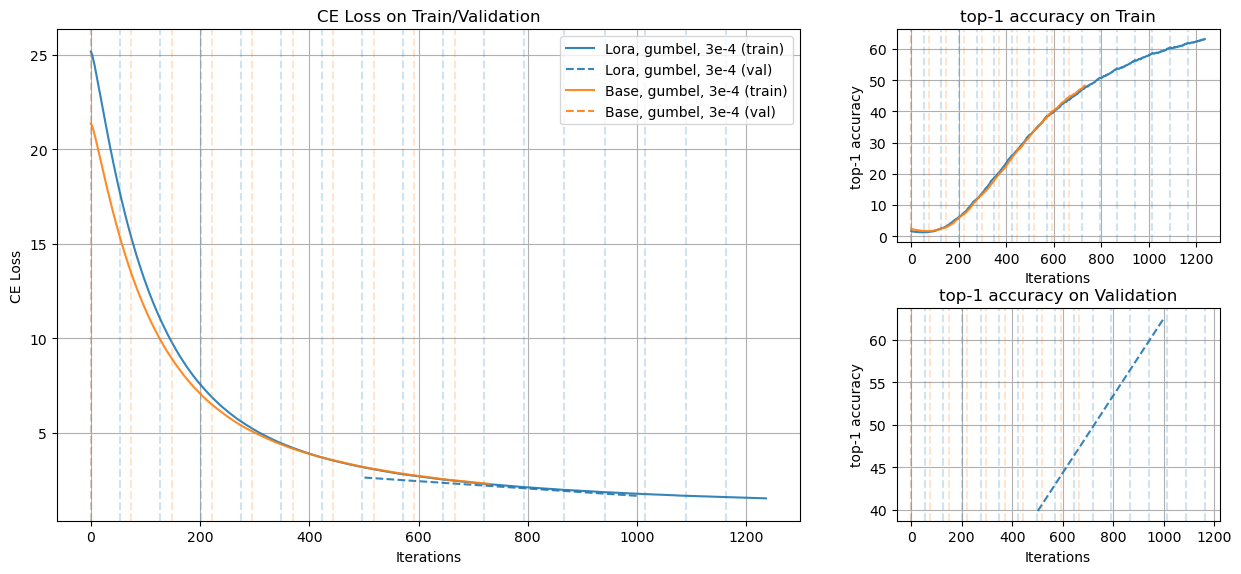

Finished Training


In [71]:
trainer.train() # with CE loss for last lin

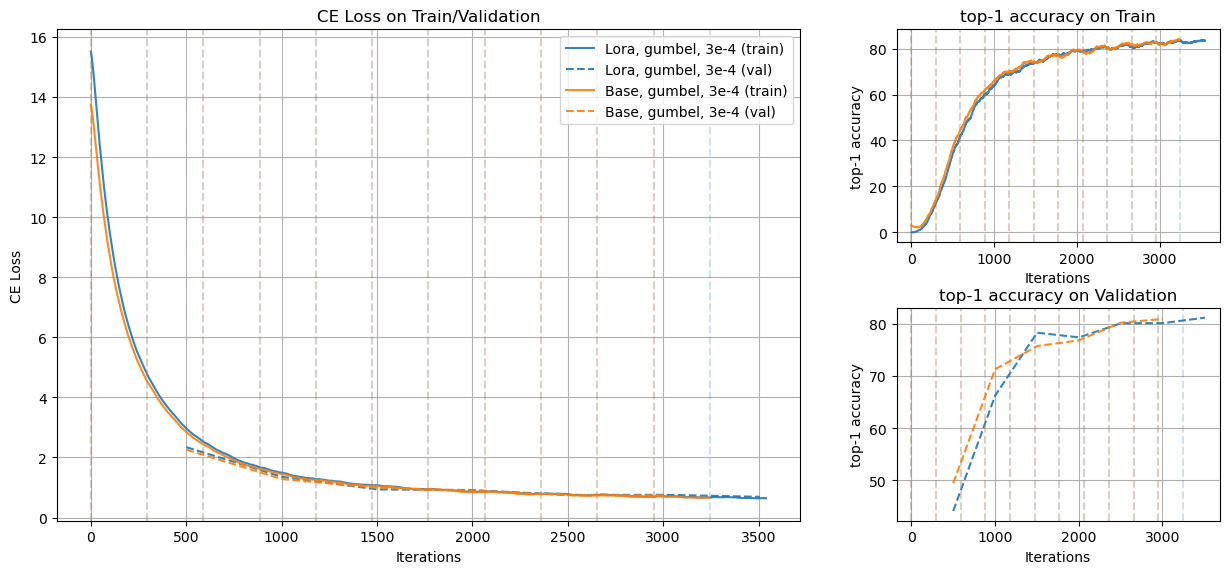

Finished Training


In [44]:
trainer.train() # with CE loss for last lin

In [58]:
config_2 = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="lora-test-altclip",
    net_types=["lora", "base"], #lora
    backbones=[Constants.altclip_link, Constants.altclip_link],
    displayed_names=["Lora, gumbel, 3e-4", "Base, gumbel, 3e-4"],
    training_methods=["gumbel", "gumbel"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
    lora_connections=["last"],
    #lora_connections=[],
)

In [59]:
trainer_2 = BottleneckTrainer(
    config_2,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
    device=device
)

`text_config_dict` is provided which will be used to initialize `AltCLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


`text_config_dict` is provided which will be used to initialize `AltCLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `AltCLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `AltCLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


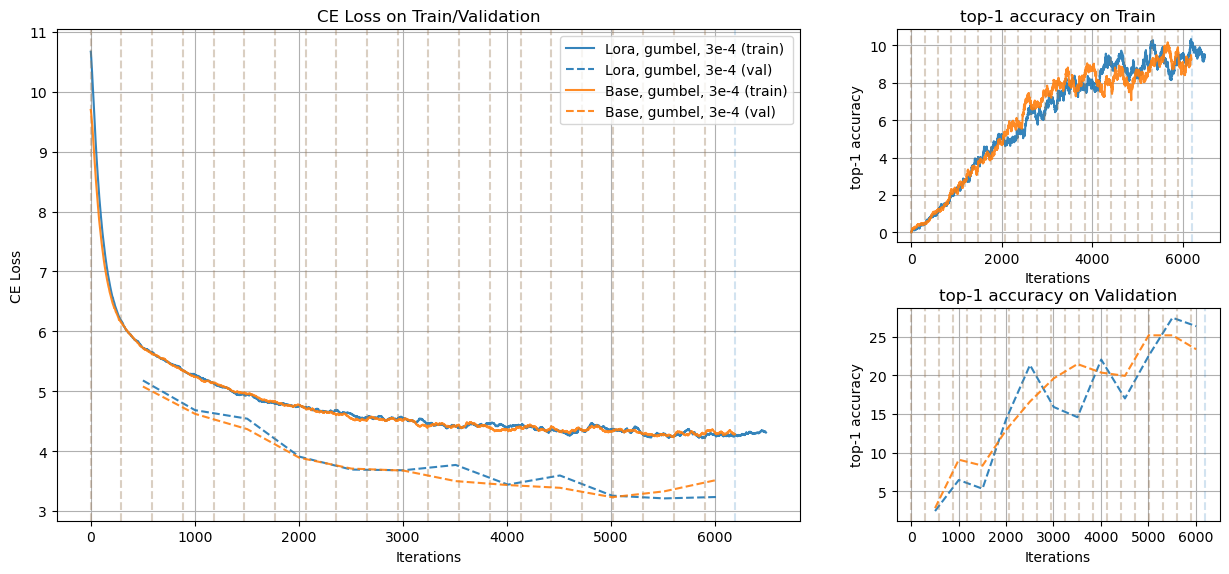

Finished Training


In [64]:
trainer_2.train() #AltCLIP

In [ ]:
plt.plot(trainer.hist[1]['val_x'], trainer.hist[1]['val_cbl_loss']) # base